In [1]:
# --- Path setup: allow importing from scripts/ ---
import sys
from pathlib import Path

# project root = previous directory

PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(sys.path)

print("Project root:", PROJECT_ROOT)

# --- Import model + helpers ---
from scripts.models import ConditionalVAE, vae_loss, linear_beta_schedule


['/home/satan/git/VAE-Timbre-Spaces', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python310.zip', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/lib-dynload', '', '/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages']
Project root: /home/satan/git/VAE-Timbre-Spaces


In [2]:
# --- Reprodutibilidade ---
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
if device.type == "cuda":
    print("gpu:", torch.cuda.get_device_name(0))
    print("torch cuda:", torch.version.cuda)

# --- Audio parameters ---
SR = 16000
N_MELS = 80
N_FFT = 2048
HOP = 256
T = 128  # fixed number of time frames

# --- Training parameters ---
BATCH_SIZE = 128
EPOCHS = 15
LR = 1e-3

# --- Conditional VAE / anti-collapse ---
LATENT_DIM = 32
BETA_MAX = 2.0
WARMUP_STEPS = 500
FREE_BITS = 0.5

print("Config OK")


device: cuda
gpu: NVIDIA GeForce RTX 3060 Ti
torch cuda: 12.1
Config OK


In [3]:
from pathlib import Path

# --- Paths (ajuste se necessário) ---
VALID_ROOT = Path("../data/nsynth-valid.jsonwav/nsynth-valid")  # mesma estrutura que você mostrou
TRAIN_ROOT = Path("../data/nsynth-train.jsonwav/nsynth-train")  # mesma estrutura que você mostrou
TEST_ROOT = Path("../data/nsynth-test.jsonwav/nsynth-test")    # mesma estrutura que você mostrou 

VALID_AUDIO_DIR = VALID_ROOT / "audio"
VALID_JSON_PATH = VALID_ROOT / "examples.json"

TEST_AUDIO_DIR = TEST_ROOT / "audio"
TEST_JSON_PATH = TEST_ROOT / "examples.json"

TRAIN_AUDIO_DIR = TRAIN_ROOT / "audio"
TRAIN_JSON_PATH = TRAIN_ROOT / "examples.json"

print("VALID_ROOT :", VALID_ROOT)
print("VALID_AUDIO_DIR exists:", VALID_AUDIO_DIR.exists(), "|", VALID_AUDIO_DIR)
print("VALID_JSON_PATH exists:", VALID_JSON_PATH.exists(), "|", VALID_JSON_PATH)

print("TRAIN_ROOT :", TRAIN_ROOT)
print("TRAIN_AUDIO_DIR exists:", TRAIN_AUDIO_DIR.exists(), "|", TRAIN_AUDIO_DIR)
print("TRAIN_JSON_PATH exists:", TRAIN_JSON_PATH.exists(), "|", TRAIN_JSON_PATH)

print("TEST_ROOT :", TEST_ROOT)
print("TEST_AUDIO_DIR exists:", TEST_AUDIO_DIR.exists(), "|", TEST_AUDIO_DIR)
print("TEST_JSON_PATH exists:", TEST_JSON_PATH.exists(), "|", TEST_JSON_PATH)
print("Paths OK")

VALID_ROOT : ../data/nsynth-valid.jsonwav/nsynth-valid
VALID_AUDIO_DIR exists: True | ../data/nsynth-valid.jsonwav/nsynth-valid/audio
VALID_JSON_PATH exists: True | ../data/nsynth-valid.jsonwav/nsynth-valid/examples.json
TRAIN_ROOT : ../data/nsynth-train.jsonwav/nsynth-train
TRAIN_AUDIO_DIR exists: True | ../data/nsynth-train.jsonwav/nsynth-train/audio
TRAIN_JSON_PATH exists: True | ../data/nsynth-train.jsonwav/nsynth-train/examples.json
TEST_ROOT : ../data/nsynth-test.jsonwav/nsynth-test
TEST_AUDIO_DIR exists: True | ../data/nsynth-test.jsonwav/nsynth-test/audio
TEST_JSON_PATH exists: True | ../data/nsynth-test.jsonwav/nsynth-test/examples.json
Paths OK


In [4]:
import json
from pathlib import Path
from collections import Counter
import numpy as np

# Escolha o split para checar: "train" | "valid" | "test"
SPLIT = "train"

ROOTS = {
    "train": TRAIN_ROOT,
    "valid": VALID_ROOT,
    "test":  TEST_ROOT,
}

root = Path(ROOTS[SPLIT])
JSON_PATH = root / "examples.json"
AUDIO_DIR = root / "audio"

print(f"SPLIT: {SPLIT}")
print("ROOT    :", root)
print("JSON    :", JSON_PATH.exists(), "|", JSON_PATH)
print("AUDIO   :", AUDIO_DIR.exists(), "|", AUDIO_DIR)

with open(JSON_PATH, "r") as f:
    examples = json.load(f)

keys = list(examples.keys())
print("Number of examples:", len(keys))

# -------------------------
# Sanity check: alguns exemplos
# -------------------------
print("\n--- Sample entries ---")
for k in keys[:3]:
    meta = examples[k]
    wav_ok = (AUDIO_DIR / f"{k}.wav").exists()
    print(
        k,
        "| wav:", wav_ok,
        "| pitch:", meta["pitch"],
        "| family:", meta["instrument_family"],
        "| source:", meta.get("instrument_source", None),
    )

# -------------------------
# Quick stats (útil pra paper e debug)
# -------------------------
pitches = [examples[k]["pitch"] for k in keys]
families = [examples[k]["instrument_family"] for k in keys]

print("\n--- Pitch stats ---")
print("min/max:", min(pitches), max(pitches))
print("mean/std:", float(np.mean(pitches)), float(np.std(pitches)))

print("\n--- Instrument family stats ---")
fam_counts = Counter(families)
print("num families:", len(fam_counts))
print("top 5:", fam_counts.most_common(5))

# -------------------------
# Wav existence check (amostrado)
# -------------------------
sample_n = min(200, len(keys))
sample_keys = keys[:sample_n]
missing = [k for k in sample_keys if not (AUDIO_DIR / f"{k}.wav").exists()]
print(f"\n--- WAV existence check (first {sample_n}) ---")
print("missing:", len(missing))
if missing:
    print("examples:", missing[:5])


SPLIT: train
ROOT    : ../data/nsynth-train.jsonwav/nsynth-train
JSON    : True | ../data/nsynth-train.jsonwav/nsynth-train/examples.json
AUDIO   : True | ../data/nsynth-train.jsonwav/nsynth-train/audio
Number of examples: 289205

--- Sample entries ---
guitar_acoustic_001-082-050 | wav: True | pitch: 82 | family: 3 | source: 0
bass_synthetic_120-108-050 | wav: True | pitch: 108 | family: 0 | source: 2
organ_electronic_120-050-127 | wav: True | pitch: 50 | family: 6 | source: 1

--- Pitch stats ---
min/max: 9 120
mean/std: 62.311657820577096 23.082482171499365

--- Instrument family stats ---
num families: 11
top 5: [(0, 65474), (4, 51821), (6, 34477), (5, 34201), (3, 32690)]

--- WAV existence check (first 200) ---
missing: 0


In [5]:
from torch.utils.data import Dataset
import torch
from pathlib import Path

CACHE_ROOT = Path("../data/nsynth_mel_cache")
print("CACHE_ROOT exists:", CACHE_ROOT.exists(), "|", CACHE_ROOT)
print("subdirs:", [p.name for p in CACHE_ROOT.iterdir() if p.is_dir()])

class NsynthMelCacheDataset(Dataset):
    def __init__(self, keys, examples, cache_dir: Path):
        self.keys = list(keys)
        self.examples = examples
        self.cache_dir = Path(cache_dir)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]

        pt_path = self.cache_dir / f"{k}.pt"
        if not pt_path.exists():
            raise FileNotFoundError(f"Missing cache file: {pt_path}")

        # x: (1, 80, T) já normalizado em [-1,1]
        x = torch.load(pt_path, weights_only=True)

        # labels como tensores (melhor pro training loop)
        pitch = torch.tensor(int(self.examples[k]["pitch"]), dtype=torch.long)
        family = torch.tensor(int(self.examples[k]["instrument_family"]), dtype=torch.long)

        return x, pitch, family, k

# -------- sanity check por split --------
TRAIN_CACHE = CACHE_ROOT / "train"
VALID_CACHE = CACHE_ROOT / "valid"
TEST_CACHE  = CACHE_ROOT / "test"

print("TRAIN_CACHE exists:", TRAIN_CACHE.exists(), "|", TRAIN_CACHE)
print("VALID_CACHE exists:", VALID_CACHE.exists(), "|", VALID_CACHE)
print("TEST_CACHE  exists:", TEST_CACHE.exists(),  "|", TEST_CACHE)



CACHE_ROOT exists: True | ../data/nsynth_mel_cache
subdirs: ['test', 'train', 'valid']
TRAIN_CACHE exists: True | ../data/nsynth_mel_cache/train
VALID_CACHE exists: True | ../data/nsynth_mel_cache/valid
TEST_CACHE  exists: True | ../data/nsynth_mel_cache/test


In [6]:
import numpy as np
import torch
import torch.nn.functional as F
import librosa
from pathlib import Path

# Garanta que esses parâmetros já existem no notebook:
# SR = 16000
# N_MELS = 80
# N_FFT = 1024
# HOP = 256
# T = 128

def wav_to_logmel_tensor(wav_path: Path) -> torch.Tensor:
    audio, sr = librosa.load(wav_path, sr=SR, mono=True)

    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP,
        n_mels=N_MELS,
        power=2.0,   # power spectrogram (default do librosa.melspectrogram)
    )

    log_mel = librosa.power_to_db(mel, ref=np.max)
    log_mel = np.clip(log_mel, -80.0, 0.0)

    # normalize dB [-80,0] -> [-1,1]
    x_norm = (log_mel + 80.0) / 80.0   # [0,1]
    x_norm = 2.0 * x_norm - 1.0        # [-1,1]

    x = torch.tensor(x_norm, dtype=torch.float32).unsqueeze(0)  # (1, 80, T')

    # pad/crop to fixed T
    time_frames = x.shape[-1]
    if time_frames >= T:
        x = x[:, :, :T]
    else:
        pad = T - time_frames
        x = F.pad(x, (0, pad))

    return x


In [7]:
import json
from pathlib import Path
from tqdm import tqdm
import torch

SPLIT = "test"

ROOTS = {
    "train": TRAIN_ROOT,
    "valid": VALID_ROOT,
    "test":  TEST_ROOT,
}

root = Path(ROOTS[SPLIT])
audio_dir = root / "audio"
json_path = root / "examples.json"

cache_root = Path("../data/nsynth_mel_cache")
cache_dir = cache_root / SPLIT
cache_dir.mkdir(parents=True, exist_ok=True)

with open(json_path, "r") as f:
    examples = json.load(f)

keys = list(examples.keys())

MAX_ITEMS = None
START_AT = 0
PROGRESS_FILE = cache_dir / "_progress.txt"

if MAX_ITEMS is None:
    end_at = len(keys)
else:
    end_at = min(len(keys), START_AT + MAX_ITEMS)

keys_slice = keys[START_AT:end_at]


skipped = written = errors = 0
first_error_printed = False

for i, k in enumerate(tqdm(keys_slice), start=START_AT):
    out_path = cache_dir / f"{k}.pt"
    if out_path.exists():
        skipped += 1
        continue

    wav_path = audio_dir / f"{k}.wav"
    try:
        x = wav_to_logmel_tensor(wav_path)
        torch.save(x, out_path)
        written += 1
    except Exception as e:
        errors += 1
        if not first_error_printed:
            print("FIRST ERROR at key:", k)
            print("wav_path:", wav_path)
            print("exception:", repr(e))
            first_error_printed = True

PROGRESS_FILE.write_text(str(end_at))
print("\nDone.")
print("written:", written, "| skipped:", skipped, "| errors:", errors)
print("Total processed:", written + skipped + errors)

100%|██████████| 4096/4096 [00:00<00:00, 170618.02it/s]


Done.
written: 0 | skipped: 4096 | errors: 0
Total processed: 4096


In [8]:
from torch.utils.data import DataLoader
import json
from pathlib import Path

# --- Roots dos splits (você já tem essas vars definidas) ---
TRAIN_ROOT = Path(TRAIN_ROOT)
VALID_ROOT = Path(VALID_ROOT)
TEST_ROOT  = Path(TEST_ROOT)

# --- Cache dirs (você já tem CACHE_ROOT definido na célula anterior) ---
TRAIN_CACHE = CACHE_ROOT / "train"
VALID_CACHE = CACHE_ROOT / "valid"
TEST_CACHE  = CACHE_ROOT / "test"

# --- Load examples.json de cada split ---
with open(TRAIN_ROOT / "examples.json", "r") as f:
    train_examples = json.load(f)
with open(VALID_ROOT / "examples.json", "r") as f:
    val_examples = json.load(f)

train_keys = list(train_examples.keys())
val_keys   = list(val_examples.keys())

print("train:", len(train_keys), "| cache:", TRAIN_CACHE)
print("val  :", len(val_keys),   "| cache:", VALID_CACHE)

# --- Datasets ---
train_ds = NsynthMelCacheDataset(train_keys, train_examples, TRAIN_CACHE)
val_ds   = NsynthMelCacheDataset(val_keys,   val_examples,   VALID_CACHE)

# --- DataLoaders ---
pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    pin_memory=pin,
    persistent_workers=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=pin,
    persistent_workers=True,
)

# sanity check batch
x, pitch, family, k = next(iter(train_loader))
print("\n[Train batch sanity check]")
print("batch x:", tuple(x.shape), x.dtype, "| min/max:", float(x.min()), float(x.max()))
print("batch pitch:", pitch.shape, pitch.dtype, "| min/max:", int(pitch.min()), int(pitch.max()))
print("batch family:", family.shape, family.dtype, "| min/max:", int(family.min()), int(family.max()))
print("first key:", k[0])


train: 289205 | cache: ../data/nsynth_mel_cache/train
val  : 12678 | cache: ../data/nsynth_mel_cache/valid

[Train batch sanity check]
batch x: (128, 1, 80, 128) torch.float32 | min/max: -1.0 1.0
batch pitch: torch.Size([128]) torch.int64 | min/max: 12 108
batch family: torch.Size([128]) torch.int64 | min/max: 0 10
first key: vocal_synthetic_001-048-100


In [9]:
import torch

# --- Model ---
cvae = ConditionalVAE(
    latent_dim=LATENT_DIM,
    pitch_vocab=128,
    cond_dim=16,      # embedding do pitch
).to(device)

optimizer = torch.optim.Adam(cvae.parameters(), lr=LR)

def beta_schedule(global_step: int) -> float:
    return linear_beta_schedule(
        global_step=global_step,
        warmup_steps=WARMUP_STEPS,
        beta_max=BETA_MAX,
    )

print("ConditionalVAE initialized")
print("Total parameters:", sum(p.numel() for p in cvae.parameters()))


ConditionalVAE initialized
Total parameters: 1223793


In [10]:
import torch

# --- get one batch ---
x, pitch, family, k = next(iter(train_loader))

x = x.to(device, non_blocking=True)                 # (B,1,80,128)
pitch = pitch.to(device, non_blocking=True)         # (B,)
family = family.to(device, non_blocking=True)       # (B,) (não usamos ainda, mas mantemos)

# --- forward ---
x_hat, mu, logvar, z = cvae(x, pitch)

print("Shapes:")
print("x     :", tuple(x.shape))
print("x_hat :", tuple(x_hat.shape))
print("mu    :", tuple(mu.shape))
print("logvar:", tuple(logvar.shape))
print("z     :", tuple(z.shape))

# --- loss ---
beta = beta_schedule(global_step=0)
total, recon, kl_raw, kl_fb = vae_loss(
    x_hat, x, mu, logvar,
    beta=beta,
    free_bits=FREE_BITS,
)

print("\nLosses (untrained sanity check):")
print("beta :", beta)
print("total:", float(total))
print("recon:", float(recon))
print("kl_raw:", float(kl_raw))
print("kl_fb :", float(kl_fb))


Shapes:
x     : (128, 1, 80, 128)
x_hat : (128, 1, 80, 128)
mu    : (128, 32)
logvar: (128, 32)
z     : (128, 32)

Losses (untrained sanity check):
beta : 0.0
total: 0.8241462707519531
recon: 0.8241462707519531
kl_raw: 0.031780906021595
kl_fb : 0.5


In [11]:
import time
import numpy as np
import torch

def train_one_epoch(model, loader, optimizer, global_step: int, log_every: int = 200):
    model.train()
    stats = {"total": [], "recon": [], "kl_raw": [], "kl_fb": []}

    for x, pitch, family, k in loader:
        x = x.to(device, non_blocking=True)
        pitch = pitch.to(device, non_blocking=True)

        beta = beta_schedule(global_step)

        x_hat, mu, logvar, z = model(x, pitch)

        total, recon, kl_raw, kl_fb = vae_loss(
            x_hat, x, mu, logvar,
            beta=beta,
            free_bits=FREE_BITS,
        )

        optimizer.zero_grad(set_to_none=True)
        total.backward()
        optimizer.step()

        stats["total"].append(total.item())
        stats["recon"].append(recon.item())
        stats["kl_raw"].append(kl_raw.item())
        stats["kl_fb"].append(kl_fb.item())

        if global_step % log_every == 0:
            print(
                f"[step {global_step}] beta={beta:.3f} "
                f"total={total.item():.3f} recon={recon.item():.3f} "
                f"kl_raw={kl_raw.item():.3f} kl_fb={kl_fb.item():.3f}"
            )

        global_step += 1

    return stats, global_step


@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    stats = {"total": [], "recon": [], "kl_raw": [], "kl_fb": []}

    for x, pitch, family, k in loader:
        x = x.to(device, non_blocking=True)
        pitch = pitch.to(device, non_blocking=True)

        x_hat, mu, logvar, z = model(x, pitch)

        # em validação, beta=1.0 só pra acompanhar números
        total, recon, kl_raw, kl_fb = vae_loss(
            x_hat, x, mu, logvar,
            beta=1.0,
            free_bits=FREE_BITS,
        )

        stats["total"].append(total.item())
        stats["recon"].append(recon.item())
        stats["kl_raw"].append(kl_raw.item())
        stats["kl_fb"].append(kl_fb.item())

    return stats


def summarize_stats(stats: dict) -> dict:
    return {k: float(np.mean(v)) for k, v in stats.items()}


In [12]:
global_step = 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    train_stats, global_step = train_one_epoch(
        cvae, train_loader, optimizer, global_step, log_every=200
    )
    val_stats = eval_one_epoch(cvae, val_loader)

    train_mean = summarize_stats(train_stats)
    val_mean = summarize_stats(val_stats)

    print(f"\nEpoch {epoch}/{EPOCHS} ({time.time() - t0:.1f}s)")
    print(
        f"  Train: total={train_mean['total']:.3f} "
        f"recon={train_mean['recon']:.3f} "
        f"kl_raw={train_mean['kl_raw']:.3f} "
        f"kl_fb={train_mean['kl_fb']:.3f}"
    )
    print(
        f"  Val  : total={val_mean['total']:.3f} "
        f"recon={val_mean['recon']:.3f} "
        f"kl_raw={val_mean['kl_raw']:.3f} "
        f"kl_fb={val_mean['kl_fb']:.3f}"
    )


[step 0] beta=0.000 total=0.889 recon=0.889 kl_raw=0.033 kl_fb=0.500
[step 200] beta=0.800 total=0.609 recon=0.207 kl_raw=0.295 kl_fb=0.503
[step 400] beta=1.600 total=0.974 recon=0.174 kl_raw=0.403 kl_fb=0.500
[step 600] beta=2.000 total=1.177 recon=0.173 kl_raw=0.394 kl_fb=0.502
[step 800] beta=2.000 total=1.152 recon=0.152 kl_raw=0.458 kl_fb=0.500
[step 1000] beta=2.000 total=1.155 recon=0.155 kl_raw=0.457 kl_fb=0.500
[step 1200] beta=2.000 total=1.166 recon=0.165 kl_raw=0.448 kl_fb=0.500
[step 1400] beta=2.000 total=1.122 recon=0.121 kl_raw=0.467 kl_fb=0.500
[step 1600] beta=2.000 total=1.148 recon=0.144 kl_raw=0.459 kl_fb=0.502
[step 1800] beta=2.000 total=1.138 recon=0.137 kl_raw=0.465 kl_fb=0.500
[step 2000] beta=2.000 total=1.125 recon=0.125 kl_raw=0.465 kl_fb=0.500
[step 2200] beta=2.000 total=1.230 recon=0.230 kl_raw=0.088 kl_fb=0.500

Epoch 1/15 (88.4s)
  Train: total=1.054 recon=0.164 kl_raw=0.422 kl_fb=0.502
  Val  : total=0.674 recon=0.169 kl_raw=0.290 kl_fb=0.504
[step 2

In [13]:
import numpy as np
import torch

N_SAMPLES = 2000  # ajuste se quiser mais/menos

cvae.eval()

mus = []
logvars = []
pitches = []
families = []
keys_out = []

def extract_mu_logvar(model, x, pitch):
    """
    Compatível com várias implementações de ConditionalVAE:
    - model.encode(x, pitch) -> (mu, logvar)
    - model.encoder(x, pitch) -> (mu, logvar)
    - model.encoder(x) -> (mu, logvar)
    """
    # 1) preferível: método encode explícito
    if hasattr(model, "encode") and callable(getattr(model, "encode")):
        out = model.encode(x, pitch)
        # pode vir (mu, logvar) ou (mu, logvar, ...)
        mu, logvar = out[0], out[1]
        return mu, logvar

    # 2) encoder pode aceitar pitch
    try:
        out = model.encoder(x, pitch)
        mu, logvar = out[0], out[1]
        return mu, logvar
    except TypeError:
        pass

    # 3) encoder sem cond
    out = model.encoder(x)
    mu, logvar = out[0], out[1]
    return mu, logvar

with torch.no_grad():
    total = 0
    for x, pitch, family, k in val_loader:
        x = x.to(device, non_blocking=True)
        pitch_dev = pitch.to(device, non_blocking=True)

        mu, logvar = extract_mu_logvar(cvae, x, pitch_dev)  # (B, latent_dim)

        bsz = mu.shape[0]
        total += bsz

        mus.append(mu.detach().cpu())
        logvars.append(logvar.detach().cpu())
        pitches.append(pitch.detach().cpu())
        families.append(family.detach().cpu())
        keys_out.extend(list(k))

        if total >= N_SAMPLES:
            break

mu_all = torch.cat(mus, dim=0)[:N_SAMPLES].numpy()
logvar_all = torch.cat(logvars, dim=0)[:N_SAMPLES].numpy()
pitch_all = torch.cat(pitches, dim=0)[:N_SAMPLES].numpy()
family_all = torch.cat(families, dim=0)[:N_SAMPLES].numpy()
keys_all = np.array(keys_out[:N_SAMPLES])

print("mu_all:", mu_all.shape)
print("logvar_all:", logvar_all.shape)
print("pitch_all:", pitch_all.shape, "| min/max:", pitch_all.min(), pitch_all.max())
print("family_all:", family_all.shape, "| unique:", len(np.unique(family_all)))
print("keys_all:", keys_all.shape)


mu_all: (2000, 32)
logvar_all: (2000, 32)
pitch_all: (2000,) | min/max: 9 118
family_all: (2000,) | unique: 10
keys_all: (2000,)


In [25]:
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

# --- Instrument family mapping (NSynth) ---
FAMILY_NAMES = {
    0: "bass",
    1: "brass",
    2: "flute",
    3: "guitar",
    4: "keyboard",
    5: "mallet",
    6: "organ",
    7: "reed",
    8: "string",
    9: "synth_lead",
    10: "vocal",
}

family_names = np.vectorize(FAMILY_NAMES.get)(family_all)

# --- PCA 2D ---
pca = PCA(n_components=2, random_state=SEED)
mu_pca = pca.fit_transform(mu_all)

print(
    "Explained variance ratio:",
    pca.explained_variance_ratio_,
    "| sum:",
    pca.explained_variance_ratio_.sum(),
)

# Data for plotly
data = {
    "pc1": mu_pca[:, 0],
    "pc2": mu_pca[:, 1],
    "pitch": pitch_all.astype(int),
    "instrument_family": family_names,  # <-- categórico
    "key": keys_all,
}

# --- Plot 1: color by instrument_family (categorical legend) ---
fig1 = px.scatter(
    data,
    x="pc1",
    y="pc2",
    color="instrument_family",
    hover_data=["pitch", "key"],
    title="PCA (mu) — color: instrument family",
)
fig1.show()

# --- Plot 2: color by pitch (continuous) ---
fig2 = px.scatter(
    data,
    x="pc1",
    y="pc2",
    color="pitch",
    hover_data=["instrument_family", "key"],
    title="PCA (mu) — color: pitch",
)
fig2.show()


Explained variance ratio: [0.972278   0.02514623] | sum: 0.99742424


In [29]:
import numpy as np
import umap.umap_ as umap
import plotly.express as px

NSYNTH_FAMILY_MAP = {
    0: "bass",
    1: "brass",
    2: "flute",
    3: "guitar",
    4: "keyboard",
    5: "mallet",
    6: "organ",
    7: "reed",
    8: "string",
    9: "synth_lead",
    10: "vocal",
}

family_labels = np.array([
    f"{int(fid)} – {NSYNTH_FAMILY_MAP.get(int(fid), 'unknown')}"
    for fid in family_all
])

# --- UMAP 2D ---
reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    init="spectral",
    learning_rate=1.0,   # <-- trocado (antes estava "auto")
    random_state=SEED,
)
mu_umap = reducer.fit_transform(mu_all)

data_umap = {
    "u1": mu_umap[:, 0],
    "u2": mu_umap[:, 1],
    "pitch": pitch_all.astype(int),
    "family_label": family_labels,  # categórico => legenda por cor
    "key": keys_all,
}

fig1 = px.scatter(
    data_umap,
    x="u1",
    y="u2",
    color="family_label",
    hover_data=["pitch", "key"],
    title="UMAP (mu) — color: instrument family",
)
fig1.show()

fig2 = px.scatter(
    data_umap,
    x="u1",
    y="u2",
    color="pitch",
    hover_data=["family_label", "key"],
    title="UMAP (mu) — color: pitch",
)
fig2.show()


/home/satan/miniconda3/envs/timbre_space_dl/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Example key: keyboard_acoustic_004-060-025
pitch: 60 | family: 4
x     min/max: -80.0 0.0
x_hat min/max: -80.57395 -4.725563


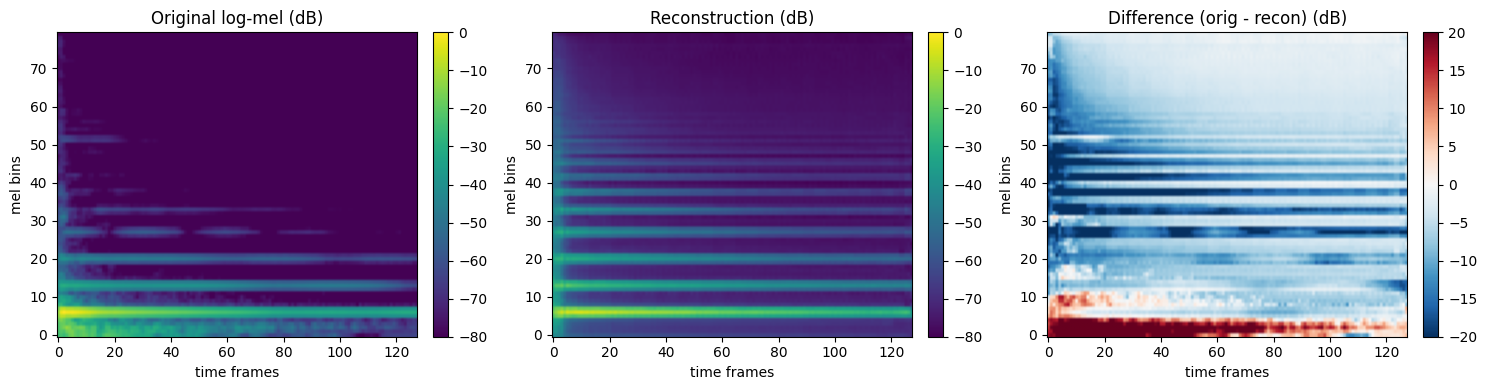

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def denormalize_db(x_norm: np.ndarray) -> np.ndarray:
    """[-1, 1] -> [-80, 0] dB"""
    x_01 = (x_norm + 1.0) / 2.0
    return x_01 * 80.0 - 80.0

# --- pick one batch from val ---
cvae.eval()
x, pitch, family, k = next(iter(val_loader))
x = x.to(device, non_blocking=True)
pitch = pitch.to(device, non_blocking=True)

with torch.no_grad():
    x_hat, mu, logvar, z = cvae(x, pitch)

i = 0
x_i    = x[i, 0].detach().cpu().numpy()
xhat_i = x_hat[i, 0].detach().cpu().numpy()

x_i_db    = denormalize_db(x_i)
xhat_i_db = denormalize_db(xhat_i)
diff_db   = x_i_db - xhat_i_db

print("Example key:", k[i])
print("pitch:", int(pitch[i].cpu()), "| family:", int(family[i].cpu()))
print("x     min/max:", x_i_db.min(), x_i_db.max())
print("x_hat min/max:", xhat_i_db.min(), xhat_i_db.max())

vmin, vmax = -80, 0
diff_lim = 20  # dB

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

im0 = axs[0].imshow(x_i_db, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
axs[0].set_title("Original log-mel (dB)")
axs[0].set_xlabel("time frames")
axs[0].set_ylabel("mel bins")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(xhat_i_db, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
axs[1].set_title("Reconstruction (dB)")
axs[1].set_xlabel("time frames")
axs[1].set_ylabel("mel bins")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(diff_db, aspect="auto", origin="lower", cmap="RdBu_r",
                    vmin=-diff_lim, vmax=diff_lim)
axs[2].set_title("Difference (orig - recon) (dB)")
axs[2].set_xlabel("time frames")
axs[2].set_ylabel("mel bins")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [32]:
import numpy as np
import torch
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def denormalize_db(x_norm: np.ndarray) -> np.ndarray:
    """[-1, 1] -> [-80, 0] dB"""
    x_01 = (x_norm + 1.0) / 2.0
    return x_01 * 80.0 - 80.0

# --- pick one batch from val ---
cvae.eval()
x, pitch, family, k = next(iter(val_loader))
x = x.to(device, non_blocking=True)
pitch = pitch.to(device, non_blocking=True)

with torch.no_grad():
    x_hat, mu, logvar, z = cvae(x, pitch)

i = 0
x_i    = x[i, 0].detach().cpu().numpy()        # (80, T)
xhat_i = x_hat[i, 0].detach().cpu().numpy()    # (80, T)

x_i_db    = denormalize_db(x_i)
xhat_i_db = denormalize_db(xhat_i)
diff_db   = x_i_db - xhat_i_db

key_i = k[i]
pitch_i = int(pitch[i].detach().cpu())
family_i = int(family[i].detach().cpu())

print("Example key:", key_i)
print("pitch:", pitch_i, "| family:", family_i)
print("x     min/max:", float(x_i_db.min()), float(x_i_db.max()))
print("x_hat min/max:", float(xhat_i_db.min()), float(xhat_i_db.max()))

# --- Plotly figure ---
vmin, vmax = -80, 0
diff_lim = 20  # dB (ajuste se quiser)

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=[
        "Original log-mel (dB)",
        "Reconstruction (dB)",
        "Difference (orig - recon) (dB)"
    ],
    horizontal_spacing=0.05
)

# Original
fig.add_trace(
    go.Heatmap(
        z=x_i_db,
        zmin=vmin, zmax=vmax,
        colorscale="Viridis",
        colorbar=dict(title="dB"),
        hovertemplate="mel=%{y}<br>t=%{x}<br>dB=%{z:.2f}<extra></extra>",
    ),
    row=1, col=1
)

# Reconstruction
fig.add_trace(
    go.Heatmap(
        z=xhat_i_db,
        zmin=vmin, zmax=vmax,
        colorscale="Viridis",
        showscale=False,
        hovertemplate="mel=%{y}<br>t=%{x}<br>dB=%{z:.2f}<extra></extra>",
    ),
    row=1, col=2
)

# Difference
fig.add_trace(
    go.Heatmap(
        z=diff_db,
        zmin=-diff_lim, zmax=diff_lim,
        colorscale="RdBu",
        colorbar=dict(title="Δ dB"),
        hovertemplate="mel=%{y}<br>t=%{x}<br>ΔdB=%{z:.2f}<extra></extra>",
    ),
    row=1, col=3
)

# Layout tweaks
fig.update_layout(
    title=f"Key: {key_i} | pitch={pitch_i} | family={family_i}",
    width=1200,
    height=420,
)

# Make axes readable (time on x, mel bins on y)
for c in [1, 2, 3]:
    fig.update_xaxes(title_text="time frames", row=1, col=c)
    fig.update_yaxes(title_text="mel bins", row=1, col=c)

fig.show()


Example key: keyboard_acoustic_004-060-025
pitch: 60 | family: 4
x     min/max: -80.0 0.0
x_hat min/max: -78.70027160644531 -6.3792724609375


In [37]:
import numpy as np
import torch
import librosa
from IPython.display import Audio, display

# -----------------------------
# Helpers
# -----------------------------
def logmel_db_to_norm(logmel_db: np.ndarray) -> np.ndarray:
    """[-80,0] dB -> [-1,1]"""
    logmel_db = np.clip(logmel_db, -80.0, 0.0)
    x01 = (logmel_db + 80.0) / 80.0
    return 2.0 * x01 - 1.0

def norm_to_logmel_db(x_norm: np.ndarray) -> np.ndarray:
    """[-1,1] -> [-80,0] dB"""
    x01 = (x_norm + 1.0) / 2.0
    return x01 * 80.0 - 80.0

def logmel_db_to_audio(
    logmel_db: np.ndarray,
    sr: int = SR,
    n_fft: int = N_FFT,
    hop_length: int = HOP,
    n_mels: int = N_MELS,
    n_iter: int = 64,
) -> np.ndarray:
    """
    Approx inversion via Griffin-Lim.
    logmel_db: (n_mels, T) in dB, expected roughly in [-80, 0]
    """
    mel_power = librosa.db_to_power(logmel_db, ref=1.0)
    stft_mag = librosa.feature.inverse.mel_to_stft(
        M=mel_power, sr=sr, n_fft=n_fft, power=1.0
    )
    wav = librosa.griffinlim(
        stft_mag, n_iter=n_iter, hop_length=hop_length, win_length=n_fft
    )
    return wav

# -----------------------------
# Pick one example (key + pitch)
# -----------------------------
# Option A: reuse batch variables if you still have them from the notebook:
# i = 0
# key_i = k[i]
# pitch_i = int(pitch[i].cpu())
ROOTS = {
    "train": TRAIN_ROOT,
    "valid": VALID_ROOT,
    "test":  TEST_ROOT,
}

root = Path(ROOTS[SPLIT])
# roots for valid
VALID_ROOT = root / "valid"

JSON_PATH = root / "examples.json"
AUDIO_DIR = root / "audio"

# Option B: set manually (edit these):
key_i = keys_all[4]           # must exist in AUDIO_DIR
pitch_i = int(pitch_all[4])   # must match that key

wav_path = VALID_AUDIO_DIR / f"{key_i}.wav"
print(wav_path.exists(), "|", wav_path)
print("key:", key_i, "| pitch:", pitch_i)
print("wav_path:", wav_path)

# -----------------------------
# Load REAL wav and compute FULL log-mel (no crop)
# -----------------------------
wav_real, _ = librosa.load(wav_path, sr=SR, mono=True)

mel = librosa.feature.melspectrogram(
    y=wav_real, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS
)
logmel_db_full = librosa.power_to_db(mel, ref=np.max)   # (80, T_full)
x_norm_full = logmel_db_to_norm(logmel_db_full)         # (80, T_full)

T_full = x_norm_full.shape[1]
print("Full mel frames:", T_full)

# -----------------------------
# Sliding window + overlap-add
# -----------------------------
cvae.eval()

win = T                 # 128
hop_win = T // 2        # 64 (50% overlap). Try 32 for smoother stitching.

# Hann window for smooth overlap-add: (1, win)
w = np.hanning(win).astype(np.float32)[None, :]

# Accumulators on REAL length
y_acc = np.zeros((N_MELS, T_full), dtype=np.float32)
w_acc = np.zeros((1, T_full), dtype=np.float32)

pitch_tensor = torch.tensor([pitch_i], device=device, dtype=torch.long)

with torch.no_grad():
    for start in range(0, T_full, hop_win):
        end = start + win

        # take real chunk (can be shorter on last window)
        chunk = x_norm_full[:, start:end]  # (80, <=win)
        valid_len = chunk.shape[1]
        if valid_len == 0:
            break

        # pad to win before feeding the model
        if valid_len < win:
            chunk = np.pad(
                chunk,
                ((0, 0), (0, win - valid_len)),
                mode="constant",
                constant_values=-1.0
            )

        # to tensor: (1,1,80,win)
        x_in = torch.tensor(chunk, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)

        # forward
        x_hat, mu, logvar, z = cvae(x_in, pitch_tensor)

        # back to numpy: (80, win)
        chunk_hat = x_hat[0, 0].detach().cpu().numpy()

        # safety: ensure win length
        if chunk_hat.shape[1] != win:
            if chunk_hat.shape[1] > win:
                chunk_hat = chunk_hat[:, :win]
            else:
                chunk_hat = np.pad(
                    chunk_hat,
                    ((0, 0), (0, win - chunk_hat.shape[1])),
                    mode="constant",
                    constant_values=-1.0
                )

        # overlap-add ONLY valid_len (prevents broadcast errors at end)
        y_acc[:, start:start+valid_len] += chunk_hat[:, :valid_len] * w[:, :valid_len]
        w_acc[:, start:start+valid_len] += w[:, :valid_len]

# Normalize overlap-add
w_acc = np.maximum(w_acc, 1e-6)
x_hat_norm_full = y_acc / w_acc  # (80, T_full)

# -----------------------------
# Invert ORIGINAL full mel vs RECONSTRUCTED full mel
# -----------------------------
x_db_full = norm_to_logmel_db(x_norm_full)
xhat_db_full = norm_to_logmel_db(x_hat_norm_full)

wav_inv_from_orig = logmel_db_to_audio(x_db_full, n_iter=64)
wav_inv_from_recon = logmel_db_to_audio(xhat_db_full, n_iter=64)

print("wav lengths (samples): real / inv(orig mel) / inv(recon mel):",
      len(wav_real), len(wav_inv_from_orig), len(wav_inv_from_recon))

# -----------------------------
# Listen
# -----------------------------
print("\n▶ REAL NSynth WAV")
display(Audio(wav_real, rate=SR))

print("▶ Inverted from ORIGINAL full log-mel (approx)  [inversion bottleneck]")
display(Audio(wav_inv_from_orig, rate=SR))

print("▶ Inverted from RECONSTRUCTED full log-mel (approx)  [model + inversion]")
display(Audio(wav_inv_from_recon, rate=SR))


True | ../data/nsynth-valid.jsonwav/nsynth-valid/audio/bass_synthetic_034-030-050.wav
key: bass_synthetic_034-030-050 | pitch: 30
wav_path: ../data/nsynth-valid.jsonwav/nsynth-valid/audio/bass_synthetic_034-030-050.wav
Full mel frames: 251
wav lengths (samples): real / inv(orig mel) / inv(recon mel): 64000 64000 64000

▶ REAL NSynth WAV


▶ Inverted from ORIGINAL full log-mel (approx)  [inversion bottleneck]


▶ Inverted from RECONSTRUCTED full log-mel (approx)  [model + inversion]


In [36]:
import librosa
from IPython.display import Audio, display

def mel_db_to_audio_librosa_mel_to_audio(logmel_db, n_iter=128):
    mel_power = librosa.db_to_power(logmel_db, ref=1.0)
    wav = librosa.feature.inverse.mel_to_audio(
        M=mel_power,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP,
        win_length=N_FFT,
        n_iter=n_iter,
        power=2.0,   # porque db_to_power retorna power
    )
    return wav

print("▶ mel_to_audio inversion | n_iter=128")
wav_inv_orig_128 = mel_db_to_audio_librosa_mel_to_audio(x_db_full, n_iter=128)
wav_inv_recon_128 = mel_db_to_audio_librosa_mel_to_audio(xhat_db_full, n_iter=128)

print("ORIG mel -> audio")
display(Audio(wav_inv_orig_128, rate=SR))

print("RECON mel -> audio")
display(Audio(wav_inv_recon_128, rate=SR))

print("▶ mel_to_audio inversion | n_iter=64")
wav_inv_orig_64 = mel_db_to_audio_librosa_mel_to_audio(x_db_full, n_iter=64)
wav_inv_recon_64 = mel_db_to_audio_librosa_mel_to_audio(xhat_db_full, n_iter=64)

print("ORIG mel -> audio")
display(Audio(wav_inv_orig_64, rate=SR))

print("RECON mel -> audio")
display(Audio(wav_inv_recon_64, rate=SR))

▶ mel_to_audio inversion | n_iter=128
ORIG mel -> audio


RECON mel -> audio


▶ mel_to_audio inversion | n_iter=64
ORIG mel -> audio


RECON mel -> audio
